# INFO

Requirements:
- Single stellar evolution simulations run with SEVN using the parsec tables with lambda_ov=0.4, lambda_ov=0.5 and for pure-He stars. 
  All the data are already in the repository stored in the folders:
      - ov04_rapid 
      - ov05_rapid
      - pureHe_rapid
- Python 3.9 or newer
- modules: pandas, numpy, matplotlib

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm, PowerNorm, Normalize
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['contour.negative_linestyle'] = 'solid'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1

def SN_info(logfile):
    """
    Read a lofgile filtering the SN formation event and getting their preSN properties
    @param logfile: path to the logfile to read
    @return: a pandas dataframe with the following columns
        - name: name of system the exploding star belongs to  (or just name of the star for SSE)
        - SID: ID of the star inside the binary (0 for primary, 1 for secondary)
        - Mass_presn: preSN mass of the star
        - MHE_presn: preSN He-core mass of the star
        - MCO_presn: preSN CO-core mass of the star
        - Mass_remnant: mass of the remnant object after the SN
        - Type: type of remnant
    """

    matchnum="[0-9]+\.?[0-9]*e?[+|-]?[0-9]*|(?i)nan"
    matchname="(?:[0-9|A-Za-z]*\_)?[0-9]*"
    matchid="[0-9]+"
    matchtype="[+|-]?\d+"
    matchexpr=f"S;({matchname});{matchid};SN;(?:{matchnum});({matchnum}):({matchnum}):({matchnum}):({matchnum}):({matchtype})"

    with open(logfile,"r") as fo:
        ma = re.findall(matchexpr,fo.read())

    na = np.array(ma)

    df = pd.DataFrame(na,columns=["name","Mass_presn","MHE_presn","MCO_presn","Mass_remnant","Type"])

    #In some rare cases, in the same timestep of a supernova explosion the companion call a repeat in this case
    #two SN events can appear for the same stare in the logfile. The last one is the right one.
    #With the following command we remove the duplicates
    df = df.drop_duplicates(subset=("name"), keep="last")

    return df.astype({"name":"int64",
                     "Mass_presn":"float",
                     "MHE_presn":"float",
                     "MCO_presn":"float",
                     "Mass_remnant":"float",
                     "Type":"int"})



def create_final_file(outfolder: str) -> pd.DataFrame:

    out = pd.read_csv(f"{outfolder}/output_0.csv")

    outf = out[out.Worldtime>0][["name","Mass"]].rename(columns={"Mass":"Mrem"})
    outi = out[out.Worldtime==0][["name","Zams","Zmet"]].rename(columns={"Zams":"Mzams"})

    outf = outf.merge(outi, on="name")
    dflog=SN_info(f"{outfolder}/logfile_0.dat")[["name","Mass_presn","MHE_presn","MCO_presn","Type"]]
    outf = outf.merge(dflog, on="name")

    return outf


def make_plot(foldername,savename,inset=True, yrange_inset=(3,26), xrange_inset=(21,44),xstep_inset=5,ystep_inset=8,Mzams_cut=None):

    Zs=(0.0001,0.0005,0.001,0.005,0.01,0.02)


    jet = cm = plt.get_cmap('plasma')
    cNorm  = LogNorm(vmin=np.min(Zs), vmax=np.max(Zs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


    folders=(f"{foldername}/sevn_output_mapelli20",f"{foldername}/sevn_output_farmer19")
    fig = plt.figure(figsize=(12,8))
    
    ax_inset=None

    gs = fig.add_gridspec(2, 2, hspace=0)

    for i,folder in enumerate(folders):
        dfo=create_final_file(folder)
        ax=fig.add_subplot(gs[0,i])
        plt.sca(ax)
        ax.axes.xaxis.set_ticklabels([])
        
        
        for j,Z in enumerate(Zs):
            ls="solid" if (j%2==0 or Z==0.02) else "dashed"
            dft=dfo[dfo.Zmet==Z]
            if Mzams_cut is not None: dft=dft[dft.Mzams<Mzams_cut]
            colorVal = scalarMap.to_rgba(Z)
            MZAMS=dft.Mzams
            MREM=np.where(dft.Mrem.isnull(),0,dft.Mrem)
            plt.plot(MZAMS,MREM,color=colorVal,label=f"$Z$={Z}",lw=2,ls=ls)
            ax.xaxis.set_major_locator(MultipleLocator(25))
            ax.xaxis.set_minor_locator(MultipleLocator(5))
            ax.yaxis.set_major_locator(MultipleLocator(20))
            ax.yaxis.set_minor_locator(MultipleLocator(5))
            ax.tick_params(axis="y", which="both", direction="in",right="on")
            ax.tick_params(axis="x", which="both", direction="in",right="on",top="on")
            ax.set_xlabel("Mzams [M$_\odot$]")
            if i==0:
                ax.set_ylabel("$M_\mathrm{rem}$ [M$_\odot$]",fontsize=label_size)
                plt.text(10,101,"PISN model: M20",fontsize=label_size)
            elif i==1:
                ax.set_ylabel("$M_\mathrm{rem}$ [M$_\odot$]",fontsize=label_size)
                plt.text(10,101,"PISN model: F19",fontsize=label_size)
            elif i==2:
                ax.set_ylabel("$M_\mathrm{rem}$ [M$_\odot$]",fontsize=label_size)
                plt.text(10,90,"PISN: Iorio+22  \n (Farmer+19)",fontsize=label_size)
            
            if  i==1 and inset:
                ax=plt.gca()
                if ax_inset is None: 
                    #ax_inset=fig.add_axes([0.85,0.79,0.11,0.17])
                    ax_inset = ax.inset_axes([0.7,0.6,0.3,0.4])
                    ax_inset.set_xlim(*xrange_inset)
                    ax_inset.set_ylim(*yrange_inset)
                    ax_inset.tick_params(axis='both', labelsize=11)
                    ax_inset.xaxis.set_major_locator(MultipleLocator(xstep_inset))
                    ax_inset.yaxis.set_major_locator(MultipleLocator(ystep_inset))
                    #ax_inset.set_xlabel("Mzams [M$_\odot$]",fontsize=11)
                    #ax_inset.set_ylabel("$M_\mathrm{rem}$ [M$_\odot$]",fontsize=11)
                    ax.indicate_inset([xrange_inset[0],yrange_inset[0],
                                           xrange_inset[1]-xrange_inset[0],
                                           yrange_inset[1]-yrange_inset[0]],edgecolor="black")

                    
                lwt = 2 if Z==0.02 else 1
                ax_inset.plot(dft.Mzams,dft.Mrem,color=colorVal,lw=lwt,ls=ls)
                plt.sca(ax)

        plt.xlim(0,200)
        plt.ylim(0,110)
        plt.grid(which="both",lw=0.1)
        
        
        if i==0 and inset: plt.legend(loc="upper right",fontsize=11)
        elif i==1 and  not inset: plt.legend(loc="upper right",fontsize=11)

        if i==1:
            ax1=fig.add_subplot(gs[i,0])
            ax2=fig.add_subplot(gs[i,1])
            for j,Z in enumerate(Zs):
                ls="solid" if (j%2==0 or Z==0.02) else "dashed"
                dft=dfo[dfo.Zmet==Z]
                colorVal = scalarMap.to_rgba(Z)
                plt.sca(ax1)
                plt.plot(dft.Mzams,dft.MHE_presn,color=colorVal,label=f"{Z}",lw=2,ls=ls)
                plt.axhline(32,ls="dashed",c="gray")
                plt.text(10,35,"32 M$_\odot$",fontsize=label_size-2)
                #plt.axhline(37,ls="dashed",c="gray")
                #plt.text(10,38.5,"37 M$_\odot$",fontsize=label_size-2)
                plt.axhline(64,ls="dashed",c="gray")
                plt.fill_between(np.linspace(0,200),32,64,color="gray",alpha=0.05)
                plt.text(10,65.5,"64 M$_\odot$",fontsize=label_size-2)
                plt.axhline(135,ls="dashed",c="gray")
                ax1.xaxis.set_major_locator(MultipleLocator(25))
                ax1.xaxis.set_minor_locator(MultipleLocator(5))
                ax1.yaxis.set_major_locator(MultipleLocator(20))
                ax1.yaxis.set_minor_locator(MultipleLocator(5))
                plt.xlim(0,200)
                plt.ylim(0,110)
                ax1.set_xlabel("$M_\mathrm{ZAMS}$ [M$_\odot$]",fontsize=label_size)
                ax1.set_ylabel("$M_\mathrm{He}$ preSN [M$_\odot$]",fontsize=label_size)
                #plt.text(10,101,"$M_\mathrm{He}$ preSN",fontsize=label_size)
                plt.sca(ax2)
                plt.plot(dft.Mzams,dft.MCO_presn,color=colorVal,label=f"$Z$={Z}",lw=2,ls=ls)
                plt.axhline(38,ls="dashed",c="gray")
                plt.text(10,39.5,"38 M$_\odot$",fontsize=label_size-2)
                plt.axhline(60,ls="dashed",c="gray")
                plt.fill_between(np.linspace(0,200),38,60,color="gray",alpha=0.05)
                plt.text(10,61.5,"60 M$_\odot$",fontsize=label_size-2)
                ax2.xaxis.set_major_locator(MultipleLocator(25))
                ax2.xaxis.set_minor_locator(MultipleLocator(5))
                ax2.yaxis.set_major_locator(MultipleLocator(20))
                ax2.yaxis.set_minor_locator(MultipleLocator(5))
                ax1.tick_params(axis="y", which="both", direction="in",right="on")
                ax1.tick_params(axis="x", which="both", direction="in",right="on",top="on")
                ax2.tick_params(axis="y", which="both", direction="in",right="on")
                ax2.tick_params(axis="x", which="both", direction="in",right="on",top="on")
                plt.xlim(0,200)
                plt.ylim(0,110)
                ax2.set_xlabel("$M_\mathrm{ZAMS}$ [M$_\odot$]",fontsize=label_size)
                ax2.set_ylabel("$M_\mathrm{CO}$ preSN [M$_\odot$]",fontsize=label_size)
                #plt.text(10,101,"$M_\mathrm{CO}$ preSN",fontsize=label_size)
            
            #ax2.legend(loc="upper left",ncols=2,fontsize=12)
            ax1.grid(which="both",lw=0.1)
            ax2.grid(which="both",lw=0.1)
            
            
            

            

    fig.tight_layout()
    fig.savefig(savename)


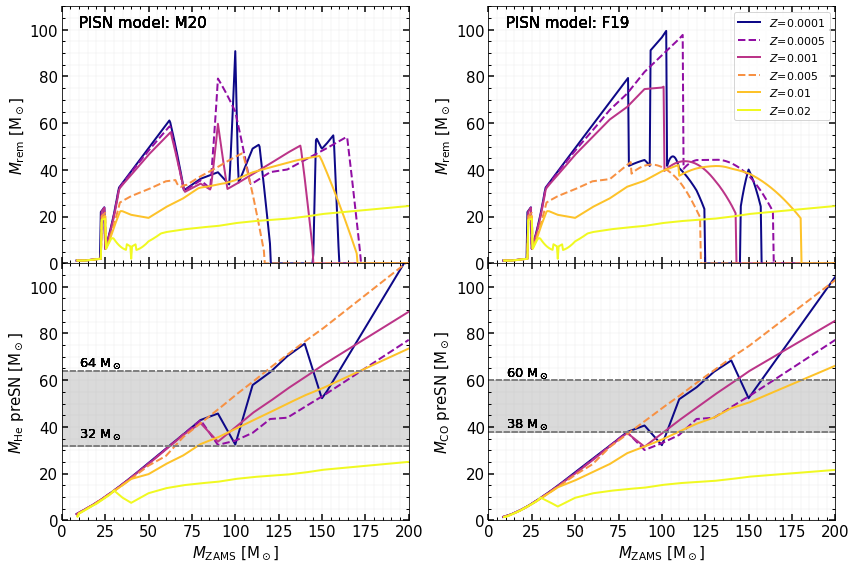

In [16]:
make_plot("ov05_rapid","Mrem_pisn_ov05.pdf",inset=False)

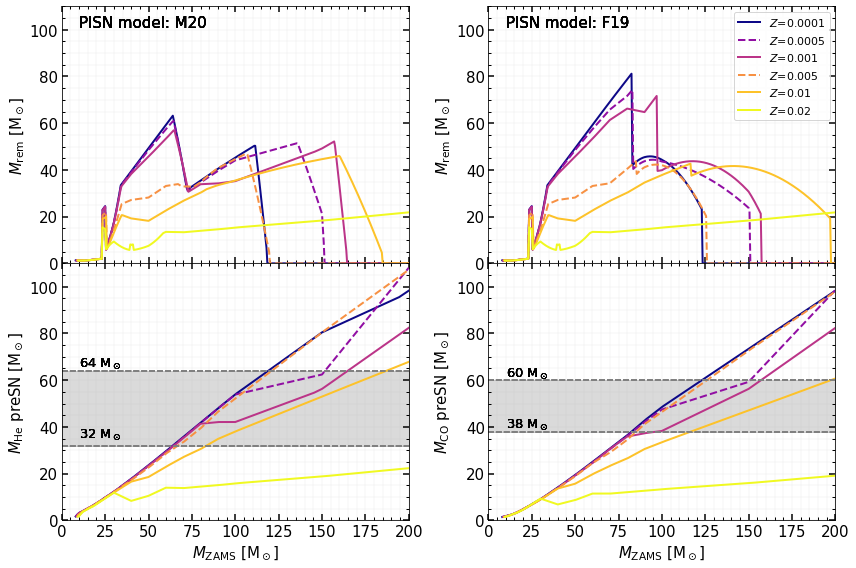

In [17]:
make_plot("ov04_rapid","Mrem_pisn_ov04.pdf",inset=False)

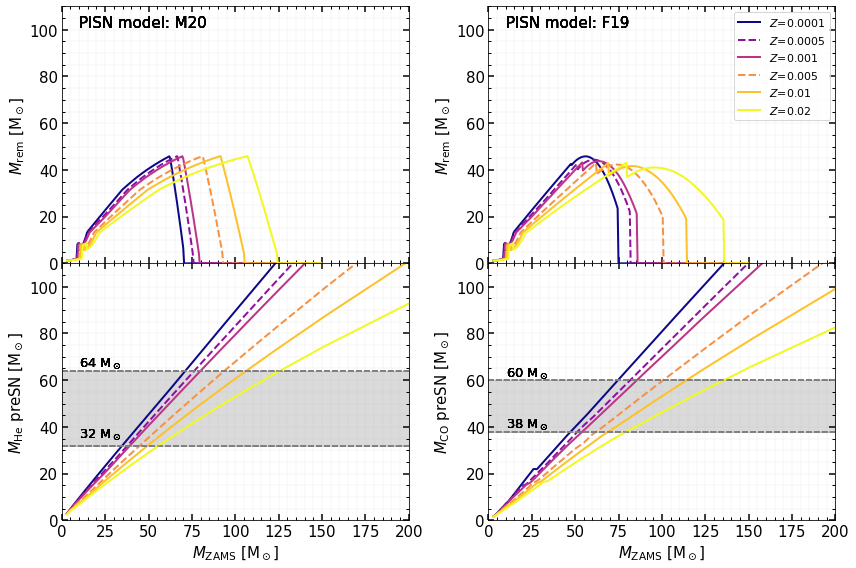

In [23]:
#make_plot("pureHe_rapid","Mrem_pisn_pureHe.pdf",inset=True,xrange_inset=(8,17),yrange_inset=(3,11),xstep_inset=3,ystep_inset=3)
make_plot("pureHe_rapid","Mrem_pisn_pureHe.pdf",inset=False,Mzams_cut=150)

/Users/giulianoiorio/miniforge3/envs/np_veclib/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


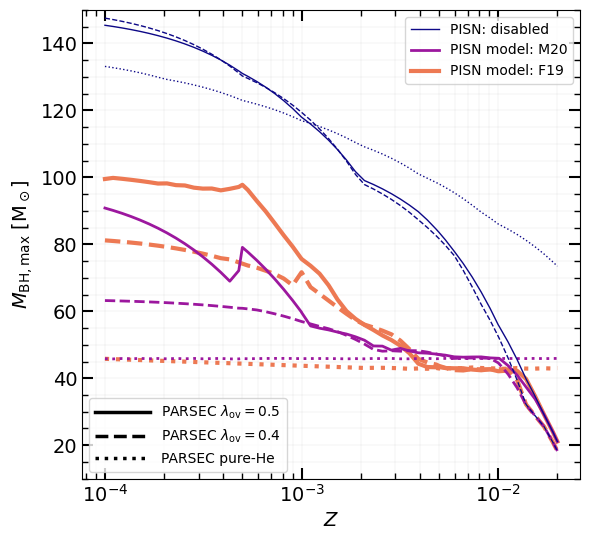

In [6]:
#Max BH
label_size =14
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

def get_MBHmax(df):

    Zs = np.sort(df.Zmet.unique())

    Mbhmax=[]
    Mzamsmax=[]
    for Z in Zs:
        dft = df[(df.Zmet==Z) & (df.Mzams<=150)][["Mzams","Mrem"]].values
        idxmax=np.nanargmax(dft[:,1])
        Mbhmax.append(dft[idxmax,1])
        Mzamsmax.append(dft[idxmax,0])

    return (np.array(Zs), np.array(Mbhmax),  np.array(Mzamsmax))

if __name__=="__main__":

    fig, ax = plt.subplots(1,1, figsize=(6,5.5))
    plt.sca(ax)

    models = {"PISN: disabled": "sevn_output_disabled",
             "PISN model: M20": "sevn_output_mapelli20",
              "PISN model: F19": "sevn_output_farmer19",
              #"PISN: Iorio+22 (Farmer+19)": "sevn_output_iorio22",
              }

    folders = {"PARSEC $\lambda_\mathrm{ov}=0.5$": ("ov05_rapid",{"ls":"solid"}),
               "PARSEC $\lambda_\mathrm{ov}=0.4$": ("ov04_rapid",{"ls":"dashed"}),
               "PARSEC pure-He": ("pureHe_rapid",{"ls":"dotted"})}

    jet = cm = plt.get_cmap('plasma')
    cNorm  = Normalize(vmin=0, vmax=len(models))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    palist = []

    for i,model in enumerate(models):
        for j,folder in enumerate(folders):
            dfoH=create_final_file(f"{folders[folder][0]}/{models[model]}")
            ZH,MbhH,MzamsH=get_MBHmax(dfoH)
            colorVal = scalarMap.to_rgba(i)

            if j==0: plt.plot(ZH,MbhH,c=colorVal,lw=i+1,zorder=100+1/(i+1),**folders[folder][1],label=model)
            else: plt.plot(ZH,MbhH,c=colorVal,lw=i+1,zorder=100+1/(i+1),**folders[folder][1])
            if i==0:
                palist+= plt.plot([0.001,0.002],[1,2],lw=2.5,c="k",**folders[folder][1])


    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))


    plt.xscale("log")
    plt.grid(which="both",lw=0.1)
    ax.legend()


    # Create the second legend and add the artist manually.
    from matplotlib.legend import Legend
    leg = Legend(ax, palist, [folder for folder in folders],
                 loc='lower left', frameon=True, handlelength=4)
    ax.add_artist(leg)

    plt.ylim(10,150)

    plt.ylabel("$M_\mathrm{BH,max}$ [M$_\odot$]",fontsize=label_size)
    plt.xlabel("$Z$",fontsize=label_size)

    ax.tick_params(axis="both", which="both",direction="in",right="on",top="on",bottom="on")

    fig.tight_layout()
    fig.savefig(f"MaxBHpisn.pdf")
    plt.show()